In [4]:
import sys
sys.path.append('../../../')


import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as md
from tqdm import tqdm
from scipy import stats
import time

import torch as tc

from BayesNewton import bayesnewton
import objax

from sklearn.linear_model import LinearRegression

from rcgp.rcgp import TemporalRCGP

In [5]:
data = pd.read_csv("../../../data/kaggle_HFT_index_futures.csv")
obs = data["last_price"].to_numpy()
obs_grid = np.arange(0, len(obs)) * 0.001 * 500

max_idx = 46800
center_idx = 2868

mean = obs[:max_idx].mean()
obs_std = obs[:max_idx].std()
obs = (obs[:max_idx] - mean)/obs_std
obs_grid = obs_grid[:max_idx]

print("Dataset Size : {}".format(len(obs)))

Dataset Size : 46800


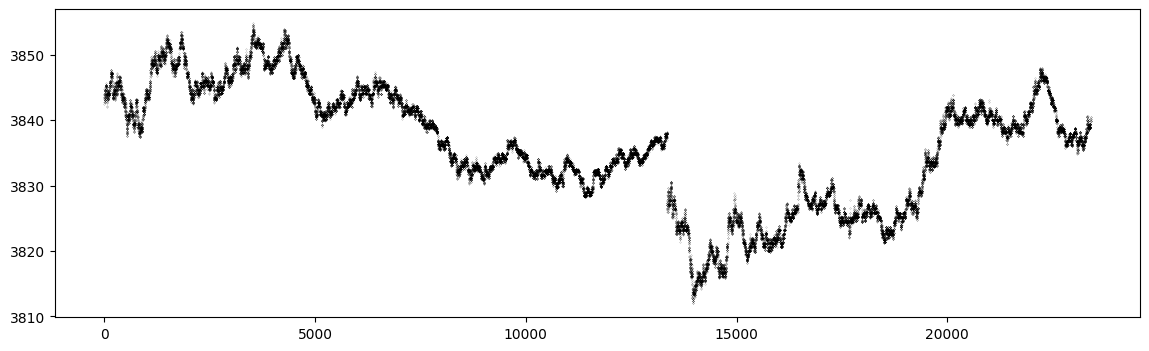

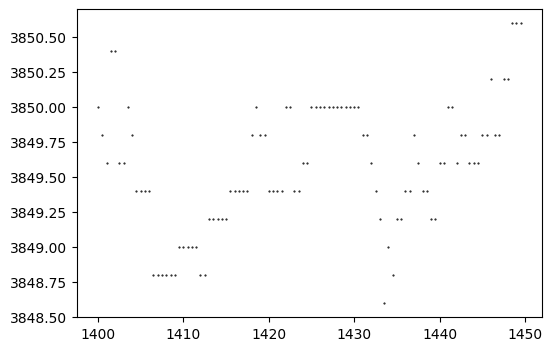

In [6]:
plt.figure(figsize=(14,4))
#plt.plot(obs_grid[outliers_idx], obs[outliers_idx] * obs_std + mean, '.',  color='red', markersize=5.)
plt.plot(obs_grid, obs * obs_std + mean, '.', color='black', markersize=0.2)

plt.figure(figsize=(6,4))
#plt.plot(obs_grid[outliers_idx], obs[outliers_idx] * obs_std + mean, '.',  color='red', markersize=10.)
plt.plot(obs_grid[2800:2900], obs[2800:2900] * obs_std + mean, '.', color='black', markersize=1)

In [7]:
def neg_log_likelihood(Y, pred, var):
    z = (Y - pred) / np.sqrt(var)
    print("Student-t", np.nanmean(stats.t.logpdf(z, df=1)))
    print("Normal", np.nanmean(stats.norm.logpdf(z)))

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def mae(predictions, targets):
    return np.abs(predictions - targets).mean()

In [8]:
def stgp(obs_grid, obs, return_output=True):

    with tc.no_grad():
        rtgp = TemporalRCGP(ts=tc.from_numpy(obs_grid).reshape(-1,1), Ys=tc.from_numpy(obs).reshape(-1,1), p=1)

        rtgp.deactivate_robustness()

        rtgp.temporal_lengthscale = 6.
        rtgp.temporal_magnitude = 6.
        rtgp.var_y = 0.14**2

        t1 = time.time()
        (preds_smooth, stds_smooth, eff), (preds_filt, covs_filt, R, Ws_norm), (ms, Ps) = rtgp.forward(smoothing=True) 
        t2 = time.time()

        if return_output:
            print("Prediction time : ", t2 - t1)
            return preds_smooth.numpy(), stds_smooth.numpy()

        else:
            return t2 - t1

In [85]:
def rtgp(obs_grid, obs, return_output=True):

    with tc.no_grad():
        rtgp = TemporalRCGP(ts=tc.from_numpy(obs_grid).reshape(-1,1), Ys=tc.from_numpy(obs).reshape(-1,1), p=1)

        rtgp.activate_robustness(func='m_pred')
        rtgp.adaptive_c()
        rtgp.temporal_lengthscale = 6.5
        rtgp.temporal_magnitude = 1.
        rtgp.var_y = 0.3**2

        t1 = time.time()
        (preds_smooth, stds_smooth, eff), (preds_filt, covs_filt, R, Ws_norm), (ms, Ps) = rtgp.forward(smoothing=True) 
        t2 = time.time()

        if return_output:
            print("Prediction time : ", t2 - t1)
            return preds_smooth.numpy(), stds_smooth.numpy()

        else:
            return t2 - t1

In [49]:
data = pd.read_csv("../../../data/kaggle_HFT_index_futures.csv")
true_obs = data["last_price"].to_numpy()[:1000]
obs = true_obs.copy()
obs_grid = (np.arange(0, len(obs)) * 0.001 * 500)[:1000]

center_idx = 500
outliers_idx = [center_idx + i for i in range(-4, 5, 1)]

for i, drop in zip(outliers_idx, [0.9995, 0.9994, 0.9992, 0.996, 0.994, 0.998, 0.998, 0.9998]):
    obs[i] = obs[i]*drop


In [10]:
def bayes_newton_EP(obs_grid, obs, return_output=True):
    #These parameters are optimized (i.e. below are starting values only)
    var_f = 1.  # GP variance
    len_f = 0.8  # GP lengthscale
    var_y = 0.8  # observation noise

    kern = bayesnewton.kernels.Matern52(variance=var_f, lengthscale=len_f)
    gauss_lik = bayesnewton.likelihoods.Gaussian(variance=var_y)
    lik = bayesnewton.likelihoods.StudentsT(df=6)
    model = bayesnewton.models.MarkovExpectationPropagationGP(kernel=kern, likelihood=lik, X=obs_grid.reshape(-1,1), Y=obs.reshape(-1,1))
    
    lr_adam = 0.1
    lr_newton = 1.0
    iters = 100
    opt_hypers = objax.optimizer.Adam(model.vars())
    energy = objax.GradValues(model.energy, model.vars())


    @objax.Function.with_vars(model.vars() + opt_hypers.vars())

    def train_op():
        model.inference(lr=lr_newton)  # perform inference and update variational params
        dE, E = energy()  # compute energy and its gradients w.r.t. hypers
        opt_hypers(lr_adam, dE)
        return E
    
    train_op = objax.Jit(train_op)

    t0 = time.time()
    for i in range(1, iters + 1):
        loss = train_op()
        #print("iter %2d, energy: %1.4f" % (i, loss[0]))
    t1 = time.time()
    if return_output:print("optimisation time: %2.2f secs" % (t1 - t0))

    t1 = time.time()
    posterior_mean, posterior_var = model.predict_y(X=obs_grid.reshape(-1,1))
    t2 = time.time()

    if return_output: print("Negative Log Predictive Density: ")
    if return_output: print(model.negative_log_predictive_density(X=obs_grid.reshape(-1,1), Y=obs.reshape(-1,1)))


    if return_output: print("Prediction time (s) : ", t2 - t1)
    if return_output:print("Lengthscale : ", model.kernel.lengthscale)
    if return_output:print("Kernel Variance : ", model.kernel.variance)
    #print("Likelihood Variance : ", model.likelihood.variance)

    if return_output:
        return np.array(posterior_mean), np.sqrt(np.array(posterior_var)), model
    else:
        return t2 - t1

In [11]:
def bayes_newton_variational(obs_grid, obs, return_output=True):
    #These parameters are optimized (i.e. below are starting values only)
    var_f = 1.  # GP variance
    len_f = 0.8  # GP lengthscale
    var_y = 0.8  # observation noise

    kern = bayesnewton.kernels.Matern52(variance=var_f, lengthscale=len_f)
    lik = bayesnewton.likelihoods.StudentsT(df=6)
    model = bayesnewton.models.MarkovVariationalGP(kernel=kern, likelihood=lik, X=obs_grid.reshape(-1,1), Y=obs.reshape(-1,1))
    
    lr_adam = 0.1
    lr_newton = 1.0
    iters = 100
    opt_hypers = objax.optimizer.Adam(model.vars())
    energy = objax.GradValues(model.energy, model.vars())


    @objax.Function.with_vars(model.vars() + opt_hypers.vars())

    def train_op():
        model.inference(lr=lr_newton)  # perform inference and update variational params
        dE, E = energy()  # compute energy and its gradients w.r.t. hypers
        opt_hypers(lr_adam, dE)
        return E
    
    train_op = objax.Jit(train_op)

    t0 = time.time()
    for i in range(1, iters + 1):
        loss = train_op()
        #print("iter %2d, energy: %1.4f" % (i, loss[0]))
    t1 = time.time()
    if return_output: print("optimisation time: %2.2f secs" % (t1 - t0))

    t1 = time.time()
    posterior_mean, posterior_var = model.predict_y(X=obs_grid.reshape(-1,1))
    t2 = time.time()

    if return_output:

        print("Negative Log Predictive Density: ")
        print(model.negative_log_predictive_density(X=obs_grid.reshape(-1,1), Y=obs.reshape(-1,1)))


        print("Prediction time (s) : ", t2 - t1)
        print("Lengthscale : ", model.kernel.lengthscale)
        print("Kernel Variance : ", model.kernel.variance)
        #print("Likelihood Variance : ", model.likelihood.variance)

        return np.array(posterior_mean), np.sqrt(np.array(posterior_var)), model
    else:
        return t2 - t1

In [110]:
def bayes_newton_laplace(obs_grid, obs, return_output=True):
    #These parameters are optimized (i.e. below are starting values only)
    var_f = 1.  # GP variance
    len_f = 0.8  # GP lengthscale
    var_y = 1.  # observation noise

    kern = bayesnewton.kernels.Matern52(variance=var_f, lengthscale=len_f)
    lik = bayesnewton.likelihoods.StudentsT(df=4)
    model = bayesnewton.models.MarkovLaplaceGP(kernel=kern, likelihood=lik, X=obs_grid.reshape(-1,1), Y=obs.reshape(-1,1))
    
    lr_adam = 0.1
    lr_newton = 0.8
    iters = 100
    opt_hypers = objax.optimizer.Adam(model.vars())
    energy = objax.GradValues(model.energy, model.vars())


    @objax.Function.with_vars(model.vars() + opt_hypers.vars())

    def train_op():
        model.inference(lr=lr_newton)  # perform inference and update variational params
        dE, E = energy()  # compute energy and its gradients w.r.t. hypers
        opt_hypers(lr_adam, dE)
        return E
    
    train_op = objax.Jit(train_op)

    t0 = time.time()
    for i in range(1, iters + 1):
        loss = train_op()
        #print("iter %2d, energy: %1.4f" % (i, loss[0]))
    t1 = time.time()
    if return_output: 
        print("optimisation time: %2.2f secs" % (t1 - t0))

    t1 = time.time()
    posterior_mean, posterior_var = model.predict_y(X=obs_grid.reshape(-1,1))
    t2 = time.time()

    if return_output:
        print("Negative Log Predictive Density: ")
        print(model.negative_log_predictive_density(X=obs_grid.reshape(-1,1), Y=obs.reshape(-1,1)))


        print("Prediction time (s) : ", t2 - t1)
        print("Lengthscale : ", model.kernel.lengthscale)
        print("Kernel Variance : ", model.kernel.variance)
        #print("Likelihood Variance : ", model.likelihood.variance)

        return np.array(posterior_mean), np.sqrt(np.array(posterior_var)), model

    else:
        return t2 - t1

In [13]:
def get_onestep_speed(method):
    n_pts = [5, 10, 100, 500, 1000, 2000, 2500, 4000, 5000, 7500, 10000, 15000, 20000, 25000, 30000, 35000, 40000, len(obs)]
    ts = []
    i = 0 #location in dataset
    for n in n_pts:
        ts.append(method(obs_grid[int(i * n):int((i+1) * n)], obs[int(i * n):int((i+1) * n)], return_output=False))
        
    return np.array(n_pts), np.array(ts)

In [ ]:
"""
#Uncomment if necessary only. Code to get execution time.

print("First...")
n_pts, rtgp_one_step_times = get_onestep_speed(rtgp);
print("Second...")
_, gp_one_step_times = get_onestep_speed(stgp);
print("Third...")
_, mep_one_step_times = get_onestep_speed(bayes_newton_EP);
print("Fourth...")
_, mvi_one_step_times = get_onestep_speed(bayes_newton_variational);
print("Fifth...")
_, mlgp_one_step_times = get_onestep_speed(bayes_newton_laplace);

pd.DataFrame({"n_data_pts" : n_pts,
              "RTGP": rtgp_one_step_times,
              "MEP" : mep_one_step_times,
              "MVI" : mvi_one_step_times,
              "MLGP" : mlgp_one_step_times,
              "STGP" : gp_one_step_times}).to_csv("./comp-time-HFT.csv")"""

First...
Second...
Third...
Fourth...
Fifth...


In [113]:
df_times=pd.read_csv("./comp-time-HFT.csv", usecols=["n_data_pts", "STGP", "RTGP", "MEP", "MVI", "MLGP"])

for col in df_times.columns[1:]:
    n_pts = df_times["n_data_pts"].to_numpy().reshape(-1,1)
    data = df_times[col].to_numpy().reshape(-1,1)
    lm = LinearRegression()
    lm.fit(n_pts, data)
    
    print("{} : Intercept, Slope, Estimate (ms) : ".format(col), lm.intercept_, lm.coef_, lm.coef_[0] * 1000)

RTGP : Intercept, Slope, Estimate (ms) :  [-0.02253105] [[0.00017525]] [0.17525073]
MEP : Intercept, Slope, Estimate (ms) :  [0.97093599] [[0.00056383]] [0.56383094]
MVI : Intercept, Slope, Estimate (ms) :  [0.11305562] [[0.00056183]] [0.56183438]
MLGP : Intercept, Slope, Estimate (ms) :  [0.1309764] [[0.00057001]] [0.57000721]
STGP : Intercept, Slope, Estimate (ms) :  [0.00998265] [[0.00015375]] [0.15375075]


(-95.0, 46900.0)

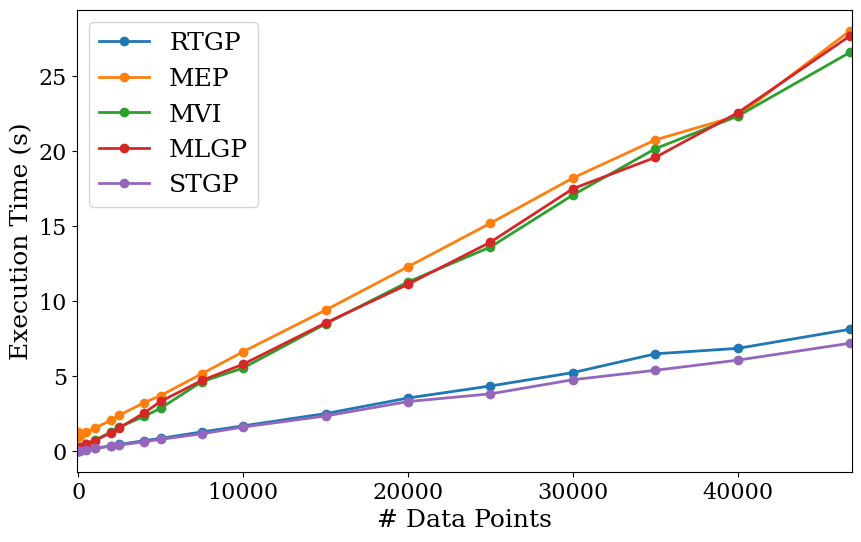

In [114]:
df_times.set_index("n_data_pts").plot(linewidth=2,
                                    style='.-',
                                    markersize=12,
                                    figsize=(10,6),
                                    fontsize=16)
plt.xlabel("# Data Points", fontsize=18)  # X-axis label
plt.ylabel("Execution Time (s)", fontsize=18)  # Y-axis label
plt.xlim(df_times["n_data_pts"].iloc[0]-100, df_times["n_data_pts"].iloc[-1]+100)
#plt.savefig("./comp-time-HFT.pdf", format='pdf', bbox_inches='tight')

In [115]:
def compute_means():

    data = pd.read_csv("../../../data/kaggle_HFT_index_futures.csv")
    true_obs = data["last_price"].to_numpy()[:1000]
    obs = true_obs.copy()
    obs_grid = (np.arange(0, len(obs)) * 0.001 * 500)[:1000]

    center_idx = 500
    outliers_idx = [center_idx + i for i in range(-4, 5, 1)]

    for i, drop in zip(outliers_idx, [0.9995, 0.9994, 0.9992, 0.996, 0.994, 0.998, 0.998, 0.9998]):
        obs[i] = obs[i]*drop
    

    mean = obs.mean()
    obs_std = obs.std()
    obs = (obs- mean)/obs_std
    true_obs = (true_obs - mean)/obs_std

    m_rtgp, P_rtgp = rtgp(obs_grid, obs)
    m_std_gp, P_std_gp = stgp(obs_grid, obs)
    mu_EP, std_EP, EP_model = bayes_newton_EP(obs_grid, obs)
    mu_VI, std_VI, VI_model = bayes_newton_variational(obs_grid, obs)
    mu_gaussnewton, std_gaussnewton, gaussnewton_model = bayes_newton_laplace(obs_grid, obs)

    return mu_gaussnewton, mu_VI, mu_EP, m_rtgp, m_std_gp, obs_grid, true_obs

mu_bayesnewton, mu_VI, mu_EP, m_rtgp, m_std_gp, obs_grid, true_obs = compute_means()

Prediction time :  0.23503708839416504
Prediction time :  0.23237395286560059
optimisation time: 4.00 secs
Negative Log Predictive Density: 
-0.5783717897392479
Prediction time (s) :  0.9187703132629395
Lengthscale :  4.828022023984271
Kernel Variance :  0.3977908402450621
optimisation time: 3.69 secs
Negative Log Predictive Density: 
-0.5897199685521641
Prediction time (s) :  0.8116750717163086
Lengthscale :  4.741261972325502
Kernel Variance :  0.4221597146277197


NameError: name 'bayes_newton_laplace' is not defined

MVI 0.15458713348473552 0.09886595080596881
RTGP 0.14378857226827244 0.10043832575316369
STGP 0.5396579780042329 0.09887510116940372
MEP 0.14360397185102022 0.09744515488120001
MLGP 0.1700309274558536 0.0880376051171654


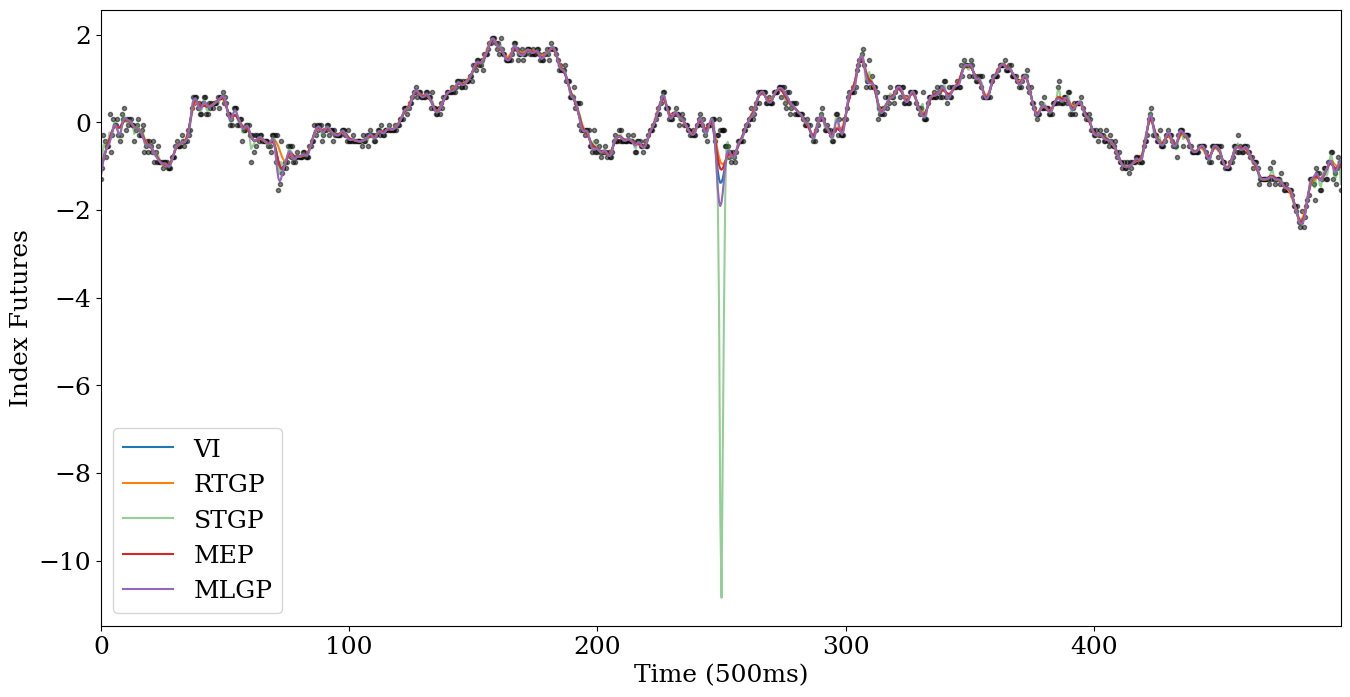

In [ ]:
plt.rc('font', family='serif', size=18)

plt.figure(figsize=(16,8))
plt.plot(obs_grid, obs_std*true_obs + mean, '.', alpha=0.5, color='black')
plt.plot(obs_grid, obs_std*mu_VI + mean, label='VI')
plt.plot(obs_grid, obs_std*m_rtgp.flatten() + mean, label="RTGP")
plt.plot(obs_grid, obs_std*m_std_gp.flatten() + mean, alpha=0.5, label="STGP")
plt.plot(obs_grid, obs_std*mu_EP + mean, label="MEP")
plt.plot(obs_grid, obs_std*mu_bayesnewton + mean, label="MLGP")
plt.xlim(obs_grid[0], obs_grid[-1])
plt.legend()

print("MVI", rmse(mu_VI, true_obs), mae(mu_VI, true_obs))
print("RTGP", rmse(m_rtgp.flatten(), true_obs), mae(m_rtgp.flatten(), true_obs))
print("STGP", rmse(m_std_gp.flatten(), true_obs), mae(m_std_gp.flatten(), true_obs))
print("MEP", rmse(mu_EP, true_obs), mae(mu_EP, true_obs))
print("MLGP", rmse(mu_bayesnewton, true_obs), mae(mu_bayesnewton, true_obs))

plt.ylabel("Index Futures")
plt.xlabel("Time (500ms)")

#plt.savefig("./rmse-comparison-plot.pdf", format='pdf', bbox_inches='tight')